# U-Net segmentation example
### Advanced Deep Learning 2024
This notebook was originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated Stefan Sommer (mailto:sommer@di.ku.dk) and Jon Sporring (mailto:sporring@di.ku.dk).

We consider the data described in:

Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006


## Installs

On non-colab system, is usually good to make an environment and install necessary tools there. E.g., anaconda->jupyter->terminal create an environment, if you have not already, and activate it:
```
conda create -n adl python=3.9
conda activate adl
```
then install missing packages such as:
```
conda install ipykernel torch matplotlib torchmetrics scikit-image jpeg
conda install -c conda-forge segmentation-models-pytorch ipywidgets
```
and if you want to add it to jupyter's drop-down menu
```
ipython kernel install --user --name=adl
```
Now reload the jupyter-notebook's homepage and make a new or load an existing file. On colab, the tools have to be installed everytime

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    !pip3 install torch matplotlib torchmetrics scikit-image segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [2]:
# install and load wandb
!pip install --quiet wandb
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


## Imports

In [3]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from torchvision.datasets.utils import download_url

from torch import Tensor

import torchmetrics

import segmentation_models_pytorch as smp

import os
import matplotlib.pyplot as plt
import numpy as np

from pprint import pformat
from skimage.transform import resize
from pathlib import Path
from glob import glob
from matplotlib.pyplot import imread
from collections import defaultdict

## Set global device

In [4]:
# GPU support?
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


## Functions
### Loading data sets

In [5]:
def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

def as_torch_dataset(x_arr, y_arr):
    """
    Takes two numpy arrays of data points and labels (x_arr and y_arr, respectively) and
    returns a torch TensorDataset object.

    Returns: torch.utils.data.TensorDataset
    """
    dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(x_arr),
        torch.FloatTensor(y_arr)
    )
    return dataset

### Visualization

In [6]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask. Segmentation is thresholded at 0.5

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    im = image.cpu().detach().numpy()
    segm = segmentation.cpu().detach().numpy()
    ax.imshow(im.squeeze(), cmap="gray")
    mask = segm < 0.5
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax

### Evaluating a model on data

In [7]:
def evaluate_model_on_single_image(model, x, device=device):
    """
    Evaluate a model on a single data point on the device.

    Returns: model(x)
    """
    with torch.no_grad():
        x = x.to(device)
        return model(x.view(1, *x.shape))

In [8]:
def evaluate_model(model, data_loader, metrics_dict, reduction=True, device=device):
    """
    Evaluate a model 'model' on all batches of a torch DataLoader 'data_loader'.
    On each batch, compute all metric functions stored in dictionary 'metrics_dict'.

    Returns: dict of metric_name: (list of batch-wise metrics if reduction == False, else single scalar)
    """

    # defaultdict(list) returns a dictionary-like object with default_factory list.
    # When a new key is encountered, an entry is automatically created of type default_factory.
    metrics = defaultdict(list)
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(data_loader):
            # Predict on batch
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            logits = model(batch_x)

            # Compute all metrics
            for metric_name, metric_func in metrics_dict.items():
                value = metric_func(logits.cpu(), batch_y.cpu()).item() #.cpu().numpy()
                metrics[metric_name].append(value)

    if reduction == True:
        # Return mean values
        return {key: np.mean(value) for key, value in metrics.items()}
    else:
        return metrics


### Saving and loading model and optimizer state

In [9]:
def save_model(model, path, optimizer=None):
    """
    Saves the state_dict of a torch model and optional optimizer to 'path'
    Returns: None
    """
    state = {"model": model.state_dict()}
    if optimizer is not None:
        state["optimizer"] = optimizer.state_dict()
    torch.save(state, path)


def load_model(model, path, optimizer=None):
    """
    Loads the state_dict of a torch model and optional optimizer from 'path'
    Returns: None
    """
    state = torch.load(path)
    model.load_state_dict(state["model"])
    if optimizer is not None:
        optimizer.load_state_dict(state["optimizer"])

### Plotting training/validation histories

In [10]:
def plot_histories(train_history=None, val_history=None, label="Loss"):
    """
    Takes a list of training and/or validation metrics and plots them
    Returns: plt.figure and ax objects
    """
    if not train_history and not val_history:
        raise ValueError("Must specify at least one of 'train_histories' and 'val_histories'")
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)

    epochs = np.arange(len(train_history or val_history))
    if train_history:
        ax.plot(epochs, train_history, label="Training", color="black")
    if val_history:
        ax.plot(epochs, val_history, label="Validation", color="darkred")

    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.legend(loc=0)

    return fig, ax

### Main training loop

We want to track the F1 score during training. This generates some additional code.

In [28]:
def run_one_epoch(model, loss, optimizer, train_loader, val_loader, n_epochs, metrics_dict, device=device):
    """
    Run 1 epoch of training
    Changes to model parameters and optimizer occour internally (state updates)
    Returns:
        two dictionaries, training and a validation metrics
    """
    train_losses = []
    for i, (batch_x, batch_y) in enumerate(train_loader):
        # Zero out stored gradients for all parameters
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        print(f"   -- Batch {i+1}/{len(train_loader)}", end=" / ")
        # Predict on batch
        logits = model(batch_x)

        # Compute loss function
        loss_tensor = loss(logits, batch_y)
        loss_scalar = loss_tensor.detach().cpu().numpy()
        train_losses.append(loss_scalar)
        print("Loss: ", loss_scalar)

        # Backprop and step
        loss_tensor.backward()
        optimizer.step()

    # Run validation
    print("   Validation running...")
    val_metrics = evaluate_model(
        model=model,
        data_loader=val_loader,
        metrics_dict=metrics_dict
    )
    # Return loss and metrics as dicts
    return {"loss": np.mean(train_losses)}, val_metrics


def merge_list_of_dicts(list_of_dicts):
    """
    Takes a list of dictionaries and merges them into a single dictionary pointing to lists

    E.g. [{"loss": 5}, {"loss": 3}, {"loss": -2, "F1": 0.5}] --> {"loss": [5, 3, -2], "F1": [0.5]}

    Returns: dict
    """
    merged = defaultdict(list)
    for dict_ in list_of_dicts:
        for value, key in dict_.items():
            merged[value].append(key)
    return merged


def training_loop(model, loss, optimizer, train_loader, val_loader, n_epochs, init_epoch=None, metrics_dict=None, save_path=None):
    """
    Run training of a model given a loss function, optimizer and a set of training and validation data.
    Supports computing additional metrics on the validation set (only) via the metrics_dict param.
    Specify save_path to store the model at each epoch.

    Returns:
        Two lists of metric dictionaries for each epoch for training and validation, specifically
    """
    train_history, val_history = [], []

    metrics_with_loss = {"loss": loss}
    if metrics_dict is not None:
        metrics_with_loss.update(metrics_dict)

    if init_epoch == None:
        init_epoch = 0
    try:
        for i in range(init_epoch, n_epochs):
            print(f"Epoch {i+1}/{n_epochs}")
            train_metrics, val_metrics = run_one_epoch(
                model=model,
                loss=loss,
                optimizer=optimizer,
                train_loader=train_loader,
                val_loader=val_loader,
                n_epochs=n_epochs,
                metrics_dict=metrics_with_loss,
            )
            print("   Mean epoch metrics:")
            print(f"   Training:   {pformat(train_metrics)}")
            print(f"   Validation: {pformat(val_metrics)}")
            train_history.append(train_metrics), val_history.append(val_metrics)

            # log to wandb
            wandb.log({'epoch': i+1, 'loss': val_metrics['loss'], 'loss-training': train_metrics, 'f1': val_metrics['f1'], 'loss-validation': val_metrics['loss']})

            if save_path:
                save_path_epoch = f"epoch_{i+1}_{save_path}"
                print(f"   Saving to: {save_path_epoch}")
                save_model(model, save_path_epoch, optimizer)
                old_path_epoch = f"epoch_{i}_{save_path}"
                if os.path.exists(old_path_epoch):
                    os.remove(old_path_epoch)

    except KeyboardInterrupt:
        print("Training stopped.")
        pass

    # Merge list of training and validation dicts into single dicts
    return merge_list_of_dicts(train_history), merge_list_of_dicts(val_history)


## Main program
### Mount Google drive when using Google Colab

In [12]:
# If you are working from Colab, better mount your google drive and change directory appropriately.
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ucph/ADL/assignment 1')
except:
    print('Google drive not mounted')
print(os.listdir())

Mounted at /content/gdrive/
['datasets', 'WandB.ipynb', 'wandb', 'epoch_10_model.ckpt', 'x_ray_segmentation_ERDA.ipynb']


### Setup database

Load database with chest X-rays with lung segmentations.

Using existing ./datasets/lung_field_dataset.npz
x train: (112, 1, 256, 256)
y train: (112, 1, 256, 256)
x val:  (12, 1, 256, 256)
y val:  (12, 1, 256, 256)
x test: (123, 1, 256, 256)
y test: (123, 1, 256, 256)


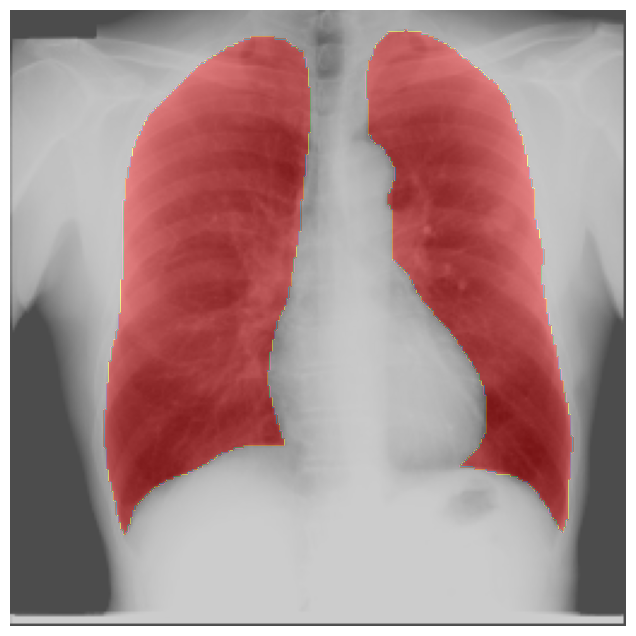

In [13]:
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
  download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
  print('Using existing', data_fn)

# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)
# Bring images into PyTorch format
x_train = np.moveaxis(x_train, 3, 1)
y_train = np.moveaxis(y_train, 3, 1)
x_val = np.moveaxis(x_val, 3, 1)
y_val = np.moveaxis(y_val, 3, 1)
x_test = np.moveaxis(x_test, 3, 1)
y_test = np.moveaxis(y_test, 3, 1)

print("x train:", x_train.shape)
print("y train:", y_train.shape)
print("x val: ", x_val.shape)
print("y val: ", y_val.shape)
print("x test:", x_test.shape)
print("y test:", y_test.shape)

# Init torch datasets
train_dataset = as_torch_dataset(x_train, y_train)
val_dataset = as_torch_dataset(x_val, y_val)
test_dataset = as_torch_dataset(x_test, y_test)

# Init dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Plot an example
fig, ax = plot_image_with_segmentation(*train_dataset[0])
plt.show()

# Sweep

In [29]:
import math
sweep_config = {
                'method': 'random',
                'metric': {'goal': 'minimize', 'name': 'loss'},
                'parameters': {
                    'batch_size': {'values': [4,8,16,32]},
                    'epochs': {'values': [10]},
                    'learning_rate': {'distribution': 'uniform',
                                      'max': 0.1,
                                      'min': 0},
                    'optimizer': {'values': ['adam', 'sgd']}
                }
 }

sweep_id = wandb.sweep(sweep_config, project="adl-ass1-sweep")

Create sweep with ID: plq3r4tr
Sweep URL: https://wandb.ai/rstern/adl-ass1-sweep/sweeps/plq3r4tr


In [30]:
def train_with_sweep(config=None):

    with wandb.init(project='adl-ass1-sweep', entity='rstern', config=config):
        config = wandb.config
        print(config)

        batch_size = config.batch_size

        # Init dataloaders
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


        config = wandb.config
        # Init U-Net model
        model = smp.Unet(encoder_name='efficientnet-b0',in_channels=1,classes=1)
        model.to(device)

        # Define optimizer
        if config.optimizer == "sgd":
            optimizer = torch.optim.SGD(model.parameters(),
                                  lr=config.learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(model.parameters(),
                                   lr=config.learning_rate)

        loss = torch.nn.MSELoss(reduction="mean")
        metrics = {"f1": torchmetrics.classification.F1Score(task='binary', num_classes=1, average="macro")}

        wandb.watch(model, loss, log="all")

        # Run training
        train_history, val_history = training_loop(
            model=model,
            loss=loss,
            optimizer=optimizer,
            train_loader=train_loader,
            val_loader=val_loader,
            init_epoch=int(0),
            n_epochs=int(config.epochs),
            metrics_dict=metrics,
            save_path="model.ckpt"
        )


        print('Finished Training')

In [31]:
# run sweep
wandb.agent(sweep_id, function=train_with_sweep, count=5)

wandb: Agent Starting Run: 0hneqbkx with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	learning_rate: 0.029950654956284708
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{'batch_size': 8, 'epochs': 10, 'learning_rate': 0.029950654956284708, 'optimizer': 'adam'}
Epoch 1/10
   -- Batch 1/14 / Loss:  1.0203481
   -- Batch 2/14 / Loss:  8.534523
   -- Batch 3/14 / Loss:  0.88121647
   -- Batch 4/14 / Loss:  0.3653717
   -- Batch 5/14 / Loss:  0.6705207
   -- Batch 6/14 / Loss:  0.8065926
   -- Batch 7/14 / Loss:  0.7370297
   -- Batch 8/14 / Loss:  0.6090442
   -- Batch 9/14 / Loss:  0.39158678
   -- Batch 10/14 / Loss:  0.29650867
   -- Batch 11/14 / Loss:  0.19172099
   -- Batch 12/14 / Loss:  0.14418536
   -- Batch 13/14 / Loss:  0.1541476
   -- Batch 14/14 / Loss:  0.17368563
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 1.0697485}
   Validation: {'f1': 0.6621551215648651, 'loss': 0.1770867332816124}
   Saving to: epoch_1_model.ckpt
Epoch 2/10
   -- Batch 1/14 / Loss:  0.1573566
   -- Batch 2/14 / Loss:  0.14855541
   -- Batch 3/14 / Loss:  0.14588752
   -- Batch 4/14 / Loss:  0.10678289
   -- Batch 5/14 / Loss:  0.1062932
   

epoch,▁▂▃▃▄▅▆▆▇█
f1,▆▄▁▃█▂▇▃▃▄
loss,█▄▃▂▁▁▁▁▁▁
loss-validation,█▄▃▂▁▁▁▁▁▁
epoch,10
f1,0.59892
loss,0.02553
loss-validation,0.02553


wandb: Agent Starting Run: q56y92y1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00302172782818414
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{'batch_size': 32, 'epochs': 10, 'learning_rate': 0.00302172782818414, 'optimizer': 'sgd'}
Epoch 1/10
   -- Batch 1/4 / Loss:  0.9348311
   -- Batch 2/4 / Loss:  0.8324678
   -- Batch 3/4 / Loss:  0.7067968
   -- Batch 4/4 / Loss:  0.55594426
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.75751}
   Validation: {'f1': 0.5584518313407898, 'loss': 0.4428030550479889}
   Saving to: epoch_1_model.ckpt
Epoch 2/10
   -- Batch 1/4 / Loss:  0.42860276
   -- Batch 2/4 / Loss:  0.32479823
   -- Batch 3/4 / Loss:  0.29243565
   -- Batch 4/4 / Loss:  0.24832216
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.3235397}
   Validation: {'f1': 0.5113648176193237, 'loss': 0.24880029261112213}
   Saving to: epoch_2_model.ckpt
Epoch 3/10
   -- Batch 1/4 / Loss:  0.24661624
   -- Batch 2/4 / Loss:  0.24947566
   -- Batch 3/4 / Loss:  0.24233636
   -- Batch 4/4 / Loss:  0.23560916
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.24

epoch,▁▂▃▃▄▅▆▆▇█
f1,▇▂▁▂▅▆██▇▆
loss,█▄▄▃▂▂▁▁▁▁
loss-validation,█▄▄▃▂▂▁▁▁▁
epoch,10
f1,0.55776
loss,0.09034
loss-validation,0.09034


wandb: Agent Starting Run: n1piy8s5 with config:
wandb: 	batch_size: 4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01002638484276961
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{'batch_size': 4, 'epochs': 10, 'learning_rate': 0.01002638484276961, 'optimizer': 'adam'}
Epoch 1/10
   -- Batch 1/28 / Loss:  1.3445102
   -- Batch 2/28 / Loss:  0.7340048
   -- Batch 3/28 / Loss:  0.62115955
   -- Batch 4/28 / Loss:  0.19167677
   -- Batch 5/28 / Loss:  0.20698988
   -- Batch 6/28 / Loss:  0.17339703
   -- Batch 7/28 / Loss:  0.119841285
   -- Batch 8/28 / Loss:  0.0830786
   -- Batch 9/28 / Loss:  0.08748743
   -- Batch 10/28 / Loss:  0.1068462
   -- Batch 11/28 / Loss:  0.10481413
   -- Batch 12/28 / Loss:  0.06295757
   -- Batch 13/28 / Loss:  0.057385705
   -- Batch 14/28 / Loss:  0.054020166
   -- Batch 15/28 / Loss:  0.045929432
   -- Batch 16/28 / Loss:  0.046963803
   -- Batch 17/28 / Loss:  0.036687516
   -- Batch 18/28 / Loss:  0.041595608
   -- Batch 19/28 / Loss:  0.03650354
   -- Batch 20/28 / Loss:  0.041328628
   -- Batch 21/28 / Loss:  0.036813058
   -- Batch 22/28 / Loss:  0.032585915
   -- Batch 23/28 / Loss:  0.031973593
   -- Batch 24/28 / Loss: 

epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▅▅▂▄▃▂▅██
loss,█▇▄▃▆▂▁▁▄▂
loss-validation,█▇▄▃▆▂▁▁▄▂
epoch,10
f1,0.76417
loss,0.01837
loss-validation,0.01837


wandb: Agent Starting Run: 420zg95p with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.08055246216574968
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{'batch_size': 32, 'epochs': 10, 'learning_rate': 0.08055246216574968, 'optimizer': 'adam'}
Epoch 1/10
   -- Batch 1/4 / Loss:  0.96628165
   -- Batch 2/4 / Loss:  2.7537622
   -- Batch 3/4 / Loss:  2.410672
   -- Batch 4/4 / Loss:  1.7994032
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 1.9825298}
   Validation: {'f1': 0.4840819537639618, 'loss': 0.3211205303668976}
   Saving to: epoch_1_model.ckpt
Epoch 2/10
   -- Batch 1/4 / Loss:  0.31676692
   -- Batch 2/4 / Loss:  0.3181492
   -- Batch 3/4 / Loss:  0.52389157
   -- Batch 4/4 / Loss:  0.5687125
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.43188006}
   Validation: {'f1': 0.6620392799377441, 'loss': 0.4338745176792145}
   Saving to: epoch_2_model.ckpt
Epoch 3/10
   -- Batch 1/4 / Loss:  0.41299766
   -- Batch 2/4 / Loss:  0.22171822
   -- Batch 3/4 / Loss:  0.14771989
   -- Batch 4/4 / Loss:  0.14985994
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.23

epoch,▁▂▃▃▄▅▆▆▇█
f1,▁█▆█▄▂▂▁▂▂
loss,▆█▃▂▂▂▁▁▁▁
loss-validation,▆█▃▂▂▂▁▁▁▁
epoch,10
f1,0.51917
loss,0.05082
loss-validation,0.05082


wandb: Agent Starting Run: 4e8ye2pz with config:
wandb: 	batch_size: 4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.039816357319257034
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{'batch_size': 4, 'epochs': 10, 'learning_rate': 0.039816357319257034, 'optimizer': 'adam'}
Epoch 1/10
   -- Batch 1/28 / Loss:  1.4076986
   -- Batch 2/28 / Loss:  3.4440837
   -- Batch 3/28 / Loss:  0.80320215
   -- Batch 4/28 / Loss:  0.39782184
   -- Batch 5/28 / Loss:  0.68323255
   -- Batch 6/28 / Loss:  0.6029174
   -- Batch 7/28 / Loss:  0.49051714
   -- Batch 8/28 / Loss:  0.4264106
   -- Batch 9/28 / Loss:  0.4558749
   -- Batch 10/28 / Loss:  0.36177403
   -- Batch 11/28 / Loss:  0.23155339
   -- Batch 12/28 / Loss:  0.17232627
   -- Batch 13/28 / Loss:  0.16897625
   -- Batch 14/28 / Loss:  0.13996115
   -- Batch 15/28 / Loss:  0.22262555
   -- Batch 16/28 / Loss:  0.16174522
   -- Batch 17/28 / Loss:  0.16455355
   -- Batch 18/28 / Loss:  0.1223914
   -- Batch 19/28 / Loss:  0.12122707
   -- Batch 20/28 / Loss:  0.11521591
   -- Batch 21/28 / Loss:  0.11724028
   -- Batch 22/28 / Loss:  0.11264342
   -- Batch 23/28 / Loss:  0.08728834
   -- Batch 24/28 / Loss:  0.09070355


epoch,▁▂▃▃▄▅▆▆▇█
f1,▇▂▁▆▅▅▃▄█▇
loss,█▃▃▂▂▂▁▂▁▁
loss-validation,█▃▃▂▂▂▁▂▁▁
epoch,10
f1,0.61859
loss,0.02036
loss-validation,0.02036


# Single Training with WandB plots


### Init model and optimizer

In [17]:
# Init U-Net model
model = smp.Unet(encoder_name='efficientnet-b0',in_channels=1,classes=1)

model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(),lr=config.learning_rate)

#print(model)

### Continue training?

In [18]:
# Specify integer, starting at 1
init_epoch = None
if init_epoch != None:
    load_model(model, f"epoch_{init_epoch}_model.ckpt", optimizer)

### Run training

In [20]:
# Define loss and metrics
loss = torch.nn.MSELoss(reduction="mean")
metrics = {"f1": torchmetrics.classification.F1Score(task='binary', num_classes=1, average="macro")}

wandb.init(project='adl-ass1-simple', entity='rstern')

# Run training
train_history, val_history = training_loop(
    model=model,
    loss=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    init_epoch=init_epoch,
    n_epochs=10,
    metrics_dict=metrics,
    save_path="model.ckpt"
)

wandb.finish()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
   -- Batch 1/7 / Loss:  0.012907678
   -- Batch 2/7 / Loss:  0.014183951
   -- Batch 3/7 / Loss:  0.01309035
   -- Batch 4/7 / Loss:  0.01153525
   -- Batch 5/7 / Loss:  0.012181133
   -- Batch 6/7 / Loss:  0.013932644
   -- Batch 7/7 / Loss:  0.014292134
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.013160449}
   Validation: {'f1': 0.8702986836433411, 'loss': 0.019355742260813713}
   Saving to: epoch_1_model.ckpt
Epoch 2/10
   -- Batch 1/7 / Loss:  0.014465806
   -- Batch 2/7 / Loss:  0.013491126
   -- Batch 3/7 / Loss:  0.01322646
   -- Batch 4/7 / Loss:  0.011356807
   -- Batch 5/7 / Loss:  0.012475941
   -- Batch 6/7 / Loss:  0.016669814
   -- Batch 7/7 / Loss:  0.013517184
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.013600449}
   Validation: {'f1': 0.8606944680213928, 'loss': 0.01878434605896473}
   Saving to: epoch_2_model.ckpt
Epoch 3/10
   -- Batch 1/7 / Loss:  0.015407964
   -- Batch 2/7 / Loss:  0.015149313

epoch,▁▂▃▃▄▅▆▆▇█
f1,██▆▆▇▇▆▃▃▁
loss-validation,█▇▄▂▂▂▁▃▁▁
epoch,10
f1,0.54366
loss-validation,0.01415


# Evaluation

### Plot training and validation histories

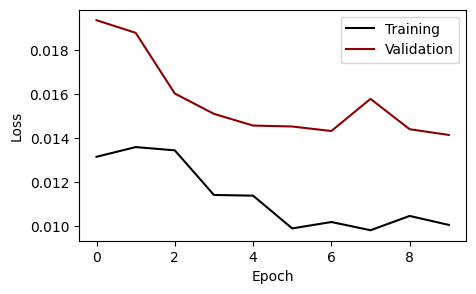

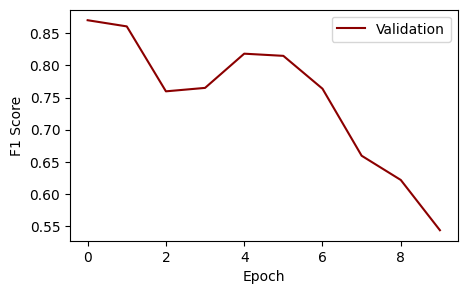

In [21]:
plot_histories(train_history['loss'], val_history['loss'], label="Loss")
plot_histories(train_history=None, val_history=val_history['f1'], label="F1 Score")
plt.show()

### Evaluate on single test-set image

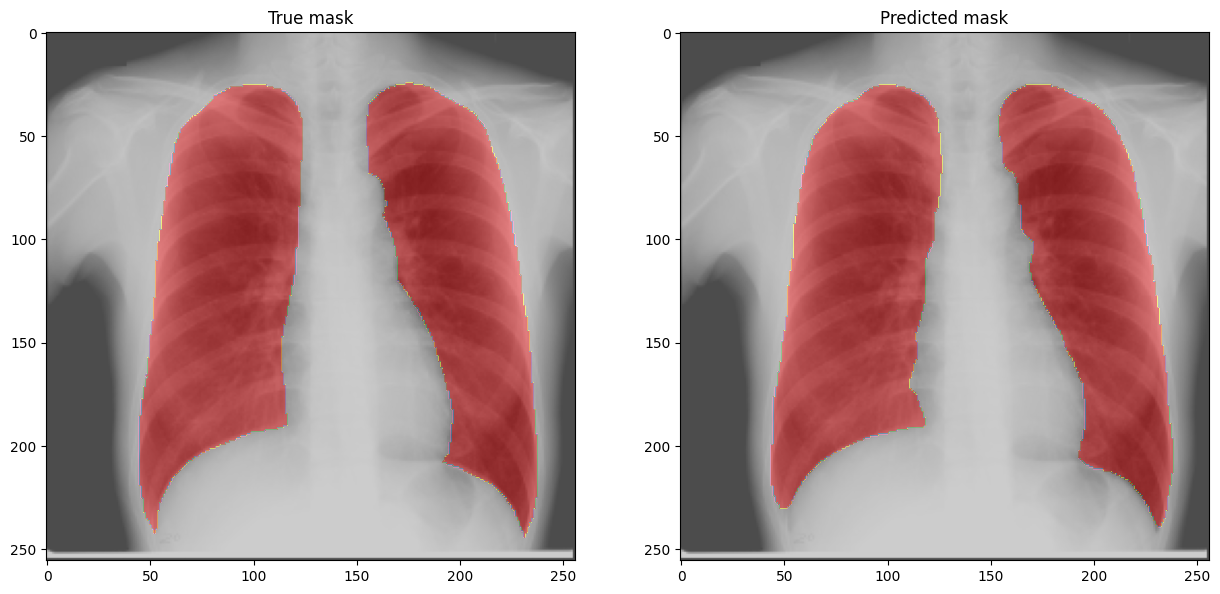

In [22]:
# Select a test image
x,y = test_dataset[0]
pred = evaluate_model_on_single_image(model, x)

# Plot the result
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15))
ax1.set_title("True mask")
ax2.set_title("Predicted mask")
plot_image_with_segmentation(x, y, ax=ax1)
plot_image_with_segmentation(x, pred, ax=ax2)
plt.show()

### Evaluate on whole test-set

In [23]:
# OBS: Returns batch-wise metrics, but test_loader has batch_size = 1
f1_test_scores = evaluate_model(model, test_loader, metrics, reduction=False)["f1"]

print("Test cases:", len(f1_test_scores))
print("Mean F1:   ", np.mean(f1_test_scores))
print("STD  F1:   ", np.std(f1_test_scores))
print("Min. F1:   ", np.min(f1_test_scores))

Test cases: 123
Mean F1:    0.5652590476400484
STD  F1:    0.1535278628845685
Min. F1:    0.32123592495918274


In [24]:
sum(p.numel() for p in model.parameters())

6250893